In [1]:
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

## Sustainable Transportation Planner for Python

Welcome to stplanpy, the Sustainable Transportation Planner for Python. This Notebook shows an example of how to use this Python package. This example focusses on origin-destination (flow) data for Stanford University, Palo Alto, and East Palo Alto. Only commutes in the San Francisco Bay Area are considered.

Lets start with importing some Python modules. The `acs` module can perform various operations on American Community Survey (ACS) flow data. The `geo` module operates on geometric data.

In [2]:
import geopandas as gpd
import matplotlib.pyplot as plt
from stplanpy import acs
from stplanpy import geo
from stplanpy import srtm
from stplanpy import od
from stplanpy import dist
from stplanpy import cycle
from stplanpy import route

Flow data is read from the example csv data file into a Pandas DataFrame using the `read_acs` function. The `clean_acs` function cleans up the data in the DataFrame. "home" is subtracted from "all", because people working from home do not make any trips. The category "Car, truck, or van -- Drove alone" is renamed to "sov", Single-occupancy Vehicle. Lastly, "active" transportation, "transit", and "carpool" columns are created. "orig_taz" and "dest_taz" are the origin and destination Traffic Analysis Zones (TAZ), respectively.

In [3]:
flow_data = acs.read_acs("od_data.csv")
flow_data = flow_data.clean_acs()

Next, county geography data is imported into a GeoDataFrame.

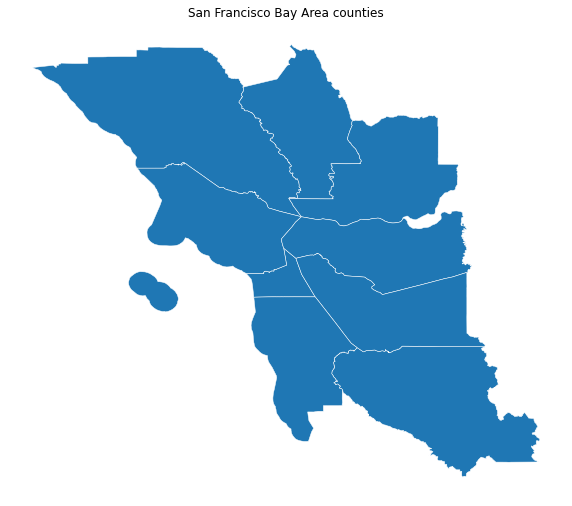

In [4]:
# Bay Area county codes
# 06 001 Alameda County
# 06 013 Contra Costa County
# 06 041 Marin County
# 06 055 Napa County
# 06 075 San Francisco County
# 06 081 San Mateo County
# 06 085 Santa Clara County
# 06 095 Solano County
# 06 097 Sonoma County
counties = ["001", "013", "041", "055", "075", "081", "085", "095", "097"]

# Read county data
county = geo.read_shp("ca-county-boundaries.zip")

# Keep only San Francisco Bay Area counties
county = county[county["countyfp"].isin(counties)]
 
# Select columns to keep
county = county[["name", "countyfp", "geometry"]]

# Plot data
county.plot(figsize=(10,10), color="C0", edgecolor="white", linewidth=0.5)
plt.title("San Francisco Bay Area counties")
plt.axis('off')
plt.show()

After importing the county geometry data, census designated place data is imported. Only East Palo Alto, Palo Alto, and Stanford University are kept.

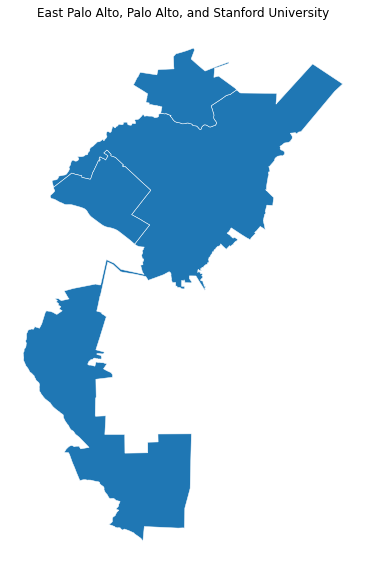

In [5]:
# Place codes
# 20956 East Palo Alto
# 55282 Palo Alto
# 73906 Stanford University
places = ["20956", "55282", "73906"]

# Read place data
place = geo.read_shp("tl_2020_06_place.zip")

# Keep only Stanford, Palo Alto, and East Palo Alto
place = place[place["placefp"].isin(places)]

# Compute which places lay inside which county
place = place.in_county(county)

# Select columns to keep
place = place[["name", "placefp", "countyfp", "geometry"]]

# Plot data
place.plot(figsize=(10,10), color="C0", edgecolor="white", linewidth=0.5)
plt.title("East Palo Alto, Palo Alto, and Stanford University")
plt.axis('off')
plt.show()

Next, Traffic Analysis Zone geometry data is imported and elevations are computed.

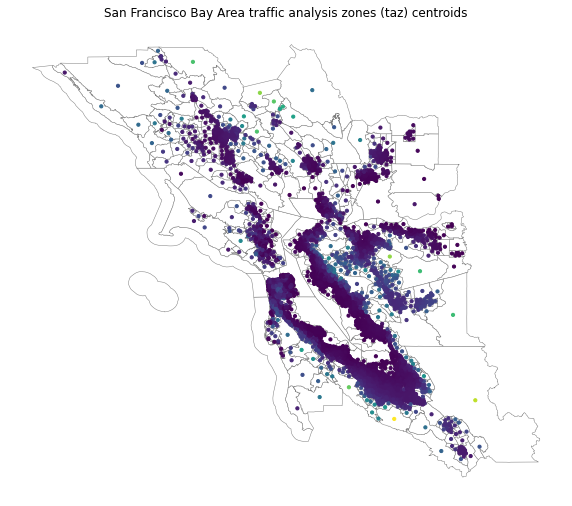

In [6]:
# Read taz data
taz = geo.read_shp("tl_2011_06_taz10.zip")

# Rename columns for consistency
taz.rename(columns = {"countyfp10":"countyfp", "tazce10":"tazce"}, inplace = True) 

# Filter on county codes
taz = taz[taz["countyfp"].isin(counties)]

# Compute centroids
taz_cent = taz.cent()

# Correct centroid locations so they are close to a road
# Google plex
taz_cent.corr_cent("00101155", -122.0780525993605, 37.42332894065777)
# Stanford research park
taz_cent.corr_cent("00100480", -122.1451249513915, 37.40713680668460)
# Facebook
taz_cent.corr_cent("00102130", -122.1487037864525, 37.48492337393505)
# San Antonio watershed
taz_cent.corr_cent("00103321", -121.8452717956161, 37.60284162184939)
# Tesla
taz_cent.corr_cent("00103023", -121.9490506527106, 37.50254728376085)
# Hayward
taz_cent.corr_cent("00103112", -122.1225131055348, 37.62298440136487)

# Compute which taz lay inside a place and which part
taz = taz.in_place(place)

# Compute elevations
taz_cent = taz_cent.elev("srtm_12_05.zip")

# Plot data
fig, ax = plt.subplots(figsize=(10,10))
ax.set_aspect("equal")
taz.plot(ax=ax, color="white", edgecolor="gray", linewidth=0.5)
taz_cent.plot(ax=ax, column="elevation", markersize=10)
plt.title("San Francisco Bay Area traffic analysis zones (taz) centroids")
plt.axis('off')
plt.show()

Modify the `flow_data` DataFrame:

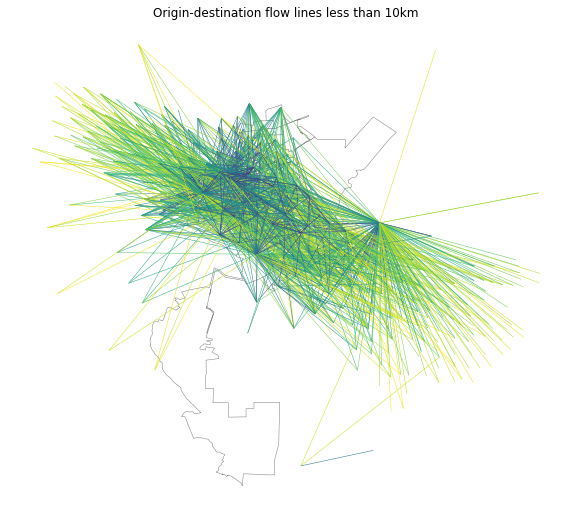

In [7]:
# Add county and place codes to data frame. This data is used to compute mode share in counties and places
flow_data = flow_data.orig_dest(taz)

# Compute origin destination lines, distances, and gradient
flow_data["geometry"] = flow_data.od_lines(taz_cent)
flow_data["distance"] = flow_data.distances()
flow_data["gradient"] = flow_data.gradient(taz_cent)

# Compute go_dutch scenario
flow_data["go_dutch"] = flow_data.go_dutch()

# Convert to GeoDataFrame
flow_data = gpd.GeoDataFrame(flow_data)
flow_data = flow_data.set_crs("EPSG:6933")

# Plot origin destination lines for distances less than 10km
fig, ax = plt.subplots(figsize=(10,10))
ax.set_aspect("equal")
taz.loc[taz["placefp"].isin(places)].plot(ax=ax, color='white', edgecolor='gray', linewidth=0.5)
flow_data.loc[flow_data["distance"] <= 10000].plot(ax=ax, column="distance", linewidth=0.5)
plt.title("Origin-destination flow lines less than 10km")
plt.axis('off')
plt.show()

Compute mode shares:

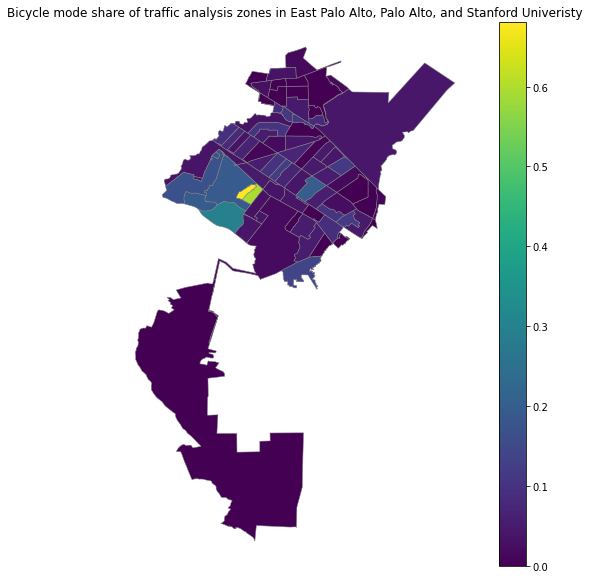

             name      bike  go_dutch    bike10      all    all10
0       Palo Alto  0.041619  0.144649  0.109430  53581.0  18569.0
2        Stanford  0.184371  0.160222  0.391057  13104.0   5636.0
5  East Palo Alto  0.039155  0.220233  0.071788   5210.0   2786.0


In [8]:
# Compute "bike", and "go_dutch" mode shares
taz[["bike", "go_dutch", "all"]] = taz.mode_share(flow_data)
place[["bike", "go_dutch", "all"]] = place.mode_share(flow_data)

# Compute mode share for trips shorter than 10km (6 miles)
taz[["bike10", "all10"]] = taz.mode_share(flow_data.loc[flow_data["distance"] <= 10000], modes=["bike"])
place[["bike10", "all10"]] = place.mode_share(flow_data.loc[flow_data["distance"] <= 10000], modes=["bike"])

# Plot data
fig, ax = plt.subplots(figsize=(10,10))
ax.set_aspect("equal")
taz.loc[taz["placefp"].isin(places)].plot(ax=ax, column="bike", edgecolor='gray', linewidth=0.5, legend=True)
plt.title("Bicycle mode share of traffic analysis zones in East Palo Alto, Palo Alto, and Stanford Univeristy")
plt.axis('off')
plt.show()

# Show mode shares
print(place[["name", "bike", "go_dutch", "bike10", "all", "all10"]])

Compute routes:

/home/arnout/.local/lib/python3.9/site-packages/stplanpy/cycle.py:74: Warning: No route found. Please relocate one of the centroids closer to a road using the corr_cent function in the geo module. The tazce codes of the centrods can be found with find_cent function in the geo module.
  return gpd.GeoSeries(fd[geom].to_crs("EPSG:4326").apply(lambda x: routes(x)), crs="EPSG:4326").to_crs(fd.crs)


     orig_taz  dest_taz
182  00103321  00101155


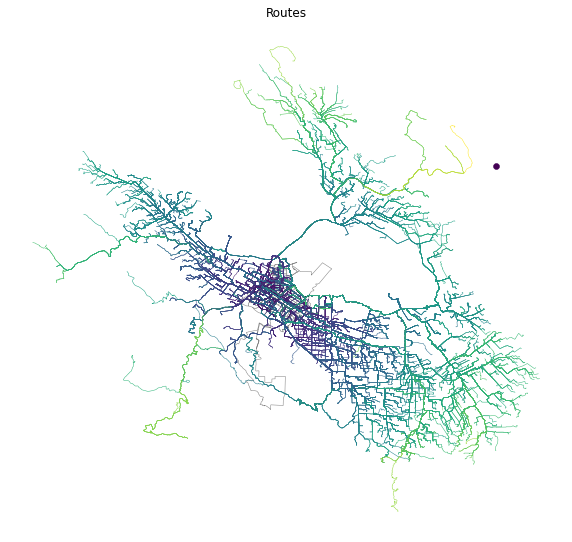

In [9]:
# Select routes shorter than 30km
flow_data = flow_data.loc[flow_data["distance"] <= 30000]

# Read the cyclestreets api key
cyclestreets_key = cycle.read_key()

# Compute routes
flow_data["geometry"] = flow_data.route_lines(api_key=cyclestreets_key)
flow_data.find_cent()

# Compute distances, gradients, and directness 
flow_data["distance"] = flow_data.distances()
flow_data["gradient"] = flow_data.gradient(taz_cent)
flow_data["directness"] = flow_data.directness()

# Compute go_dutch scenario
flow_data["go_dutch"] = flow_data.go_dutch()

# Convert to GeoDataFrame
flow_data = gpd.GeoDataFrame(flow_data)
flow_data = flow_data.set_crs("EPSG:6933")

# Plot routes
fig, ax = plt.subplots(figsize=(10,10))
ax.set_aspect("equal")
taz.loc[taz["placefp"].isin(places)].plot(ax=ax, color='white', edgecolor='gray', linewidth=0.5)
flow_data.plot(ax=ax, column="distance", linewidth=0.5)
plt.title("Routes")
plt.axis('off')
plt.show()